In [1]:
import numpy as np
import warnings 
from sklearn.model_selection import train_test_split
import scipy as scio
from scipy.spatial.distance import pdist
from scipy.linalg import cho_factor, cho_solve, cholesky
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics import mean_squared_error
from sklearn.utils import check_array, check_random_state
from sklearn.linear_model.ridge import _solve_cholesky_kernel as kernel_solve
from time import time

%matplotlib inline
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

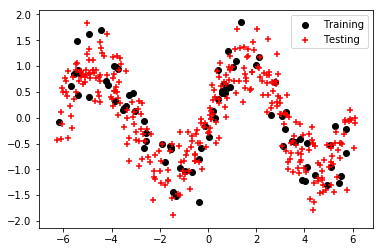

In [2]:
# generate datasets
random_state = 123
num_points = 2000

x_data = np.linspace(-2*np.pi, 2*np.pi, num=num_points)
y_data = np.sin(x_data)

# add some noise
generator = check_random_state(random_state)
y_data += 0.4 * generator.randn(num_points)

# convert to 2D, float array for scikit-learn input
x_data = x_data[:, np.newaxis].astype(np.float)
y_data = y_data[:, np.newaxis].astype(np.float)


# split data into training and testing
train_percent = 0.2

x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, train_size=train_percent,
    random_state=random_state
)

# plot the training data
fig, ax = plt.subplots()

ax.scatter(x_train[::5], y_train[::5], color='k', label='Training')
ax.scatter(x_test[::5], y_test[::5], color='r', marker='+', label='Testing')

ax.legend()
plt.show()

# remove the mean from the training data
y_mean = np.mean(y_train)

y_train -= y_mean
y_test -= y_mean

In [3]:
# parameter heuristics
mean_sigma = np.mean(pdist(x_train, metric='euclidean'))
lam = 1.0

mean_gamma = 1 / (2 * mean_sigma ** 2)

# construct kernel matrices
K_train = rbf_kernel(X=x_train, gamma=mean_gamma)
K_test = rbf_kernel(X=x_train, Y=x_test, gamma=mean_gamma)

### Solving the Inversion Problem

In [4]:
# slow method: solve problem
t0 = time()
weights = scio.linalg.solve(K_train + lam * np.eye(x_train.shape[0]), 
                      y_train)
t1 = time() - t0
print('Time taken for solve: {:.4f} secs'.format(t1))

Time taken for solve: 0.0151 secs


### Predictions


In [5]:
y_pred = K_test.T @ weights

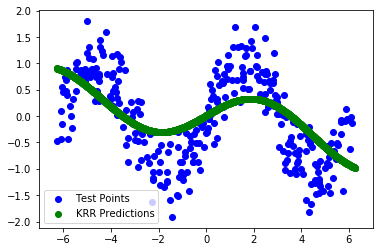

In [7]:
fig, ax = plt.subplots()

ax.scatter(x_test[::5], y_test[::5], color='b', label='Test Points')
ax.scatter(x_test, y_pred, color='g', label='KRR Predictions')


ax.legend()
plt.show()

#### Cross Validation

In [8]:
# split training data into training and validation
validation_percent = 0.2
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train, y_train, test_size=validation_percent,
    random_state=random_state)

num_parameters = 20

# sigma values
mean_sigma = np.mean(pdist(x_train, metric='euclidean'))

mean_gamma = 1 / (2 * mean_sigma ** 2)

min_sigma = np.log(mean_sigma * 0.1)
max_sigma = np.log(mean_sigma * 10)
sigma_values = np.logspace(min_sigma, max_sigma, num_parameters)
gamma_values = 1 / (2 * sigma_values ** 2)

# lambda values
lam_values = np.logspace(-7, 2, num_parameters)

In [9]:


lowest_error = np.inf

t0 = time()
for igamma in gamma_values:
    for ilam in lam_values:
        
        # Construct Kernel Matrices
        K_train = rbf_kernel(X=x_train, gamma=igamma)
        K_valid = rbf_kernel(X=x_train, Y=x_valid, gamma=igamma)
        
        # find the weights
        weights = scio.linalg.solve(
            K_train + ilam * np.eye(x_train.shape[0]),y_train)
        
        # predict new datapoints
        y_pred = K_valid.T @ weights
        
        # get error measure
        mse = mean_squared_error(y_pred, y_valid)
        
        # grab best value
        if mse < lowest_error:
            lowest_error = mse
            best_gamma = igamma
            best_lam = ilam
        
t1 = time() - t0

Lowest Mean Squared Error: 0.15388120304599803
Best sigma: 3.779, lam: 0.0018329807108324338
Time Taken for parameters: 3.2583 secs


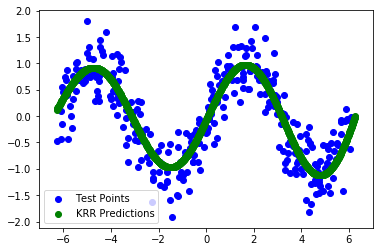

In [10]:
print('Lowest Mean Squared Error: {}'.format(lowest_error))
best_sigma = np.sqrt(1 / (2 * best_gamma))
print('Best sigma: {:.3f}, lam: {}'.format(best_sigma, best_lam))
print('Time Taken for parameters: {:.4f} secs'.format(t1))

# Construct Kernel Matrices
K_train = rbf_kernel(X=x_train, gamma=best_gamma)
K_test = rbf_kernel(X=x_train, Y=x_test, gamma=best_gamma)

# find the weights
weights = scio.linalg.solve(
    K_train + best_lam * np.eye(x_train.shape[0]),y_train)

# predict new datapoints
y_pred = K_test.T @ weights

# plot the results
fig, ax = plt.subplots()

ax.scatter(x_test[::5], y_test[::5], color='b', label='Test Points')
ax.scatter(x_test, y_pred, color='g', label='KRR Predictions')


ax.legend()
plt.show()